In [162]:
import psycopg2
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [163]:
from src.load_review_data import ReviewDataLoader
rdl = ReviewDataLoader()
df = rdl.retrieve_all_reviews()
#df = rdl.retrieve_reviews('LG Electronics 65UJ6300 65-Inch 4K Ultra HD Smart LED TV (2017 Model)')
df.head(2)

,id,product,url,p_no,r_no,r_stars,r_date,r_name,r_title,r_text,r_comments,brand_name,category,model,rating,reviews
0,6897,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,https://www.amazon.com/LG-Electronics-55UJ6300...,14,134,4.0 out of 5 stars,"February 10, 2018",Richard Monigold,Four Stars,nice tv,Verified Purchase Helpful No...,LG,tv,55UJ6300,4,Four Stars nice tv
1,6898,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,https://www.amazon.com/LG-Electronics-55UJ6300...,14,135,5.0 out of 5 stars,"May 15, 2018",Amazon Customer,Five Stars,Love it,Verified Purchase Helpful No...,LG,tv,55UJ6300,5,Five Stars Love it


In [191]:
df_new = df.copy()
df_new = df_new[df_new['r_stars'].apply(lambda x: x in ['5.0 out of 5 stars','4.0 out of 5 stars','2.0 out of 5 stars','1.0 out of 5 stars'])]
df_new['rating'] = df_new['r_stars'].apply(lambda x: 1 if x in ['4.0 out of 5 stars','5.0 out of 5 stars'] else 0)
df_new['reviews'] = df['r_title'] + ' ' + df['r_text']
df_new['review_length'] = df['r_text'].apply(lambda x: len(x))
df_new = df_new[['rating','product','reviews','model','review_length']]
df_new = df_new[df_new['review_length'] < 1000]
df_new = df_new[df_new['review_length'] > 10]
df_new.head(2)

,rating,product,reviews,model,review_length
3,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,Five Stars Great Value,55UJ6300,11
7,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,"Four Stars Very nice to, Im satisfied.",55UJ6300,27


In [192]:
df_new.count()

rating           7073
product          7073
reviews          7073
model            7073
review_length    7073
dtype: int64

In [195]:
from src.LdaReviewAnalyzer import LdaReviewAnalyzer
lda = LdaReviewAnalyzer(num_topics=2)
lda.build_vectorize(df_new)
lda.fit(df_new)

In [196]:
data_vectorized = lda.vectorize()

In [197]:
l = np.argsort(np.sum(data_vectorized,axis=0))[:,-50:]

In [8]:
l

matrix([[2530, 2734, 1085, 2275, 1832,  324, 2169,  956, 2532, 1811,
         1844, 2202,  487, 1638, 2011,  392, 2859,  736,  508,  155,
          947, 1848,  326, 1044, 2992,  277,   98, 1273,  385,  257,
         1034, 3216, 3160,  218,  965, 2253, 1195, 3226,  274,  103,
         2626, 1595, 2327,  878, 2143, 2669, 2216, 1649, 1222, 1088]])

In [198]:
np.sum(data_vectorized,axis=0)[:,549]

matrix([[4]], dtype=int64)

In [204]:
lda.transform()
for i in l.reshape(-1,1):
    #print(lda.vectorizer.get_feature_names()[int(i)])
    #print(np.sum(data_vectorized,axis=0)[:,int(i)])

SyntaxError: unexpected EOF while parsing (<ipython-input-204-440b75fff593>, line 4)

In [269]:
import pickle
from src.w2v_review_analyzer import W2VReviewAnalyzer
w2v = W2VReviewAnalyzer(pd.DataFrame())
w2v.model = pickle.load(open('static/w2v.pkl','rb'))
from src.w2v_review_analyzer2 import W2VReviewAnalyzer2
w2 = W2VReviewAnalyzer2()
w2.fit2(df_new)


In [229]:
w2v.model.wv.most_similar('samsung')

[('lg', 0.9131869077682495),
 ('panasonic', 0.8811842799186707),
 ('vizio', 0.8757293224334717),
 ('sony', 0.816213071346283),
 ('toshiba', 0.7805286645889282),
 ('westinghouse', 0.7244380712509155),
 ('tcl', 0.7110095024108887),
 ('bravia', 0.7023191452026367),
 ('lg.', 0.6951792240142822),
 ('panasonic_plasma', 0.6894485950469971)]

In [267]:
doc2 = "Image quality is almost too good."

In [271]:
doc3 = "This TV was part of my 4K upgrade plan. I updated the TV, Xbox, PS4, and Apple TV. So far the experience has been really good. The Apple TV recognized the new TV right away and configured itself to take advantage of all of the available features. The Xbox and PS4 took a little more time to setup because they each use different nomenclature for features than the TV. Plus I had to turn the features on for each connection to the TV, so it was not Plug and Play. Fortunately both the Xbox and PS4 have ways to verbosely test the connection. Once dialed in, everything is fantastic. Games like Horizon Zero Dawn and Forza 7 look fantastic. Movies and TV shows are so good, the look like high quality computer renders. Sound quality is great too. Much better than my last TV, and it was pretty good. The TV was shipped with version 3 of WebOS, not version 4, which had been out for some time. I asked the TV to look for updates and it never found them. It wasn’t until two days later when it finally found the update on its own. After the update, the Apple TV recognized the change and made configuration changes to adjust.A truly great TV, but you will need to dig around its menus and those of your devices to set it up properly. Oh, and one thing that I almost forgot. When I first started using it, everything was dark. Adjusting the image didn’t help. There is an energy saving feature that you have to turn off. Took me a while to find that."

In [392]:
w2.df_prod['rating'][16]

1

In [294]:
w2.df_prod['review_trigrams'][16]

'awesome uhd great_investment display pull crisp high_def_quality setting adjust your_room_lighting video need easy can_launch netflix amazon_prime push button'

In [343]:
w2.df_prod['reviews']

3                                  Five Stars Great Value
7                  Four Stars Very nice to, Im satisfied.
8                    Five Stars Great TV and great value.
9                     One Star It was broken upon arrival
10                      Decent television So far so good!
11      Five Stars arrived on time great picture easy ...
12                    Five Stars Love the quality picture
13      Hint: Turn OFF Smart Picture Mode Hint: Turn o...
14      43UJ6300 Needed an upgrade for my 7yr old HDTV...
15      The quality is awesome, very good bang for the...
16      Awesome tv! This UHD tv was definitely a great...
17      Bargain for the price! I ordered this after an...
18      Good price Good TV for the price. The biggest ...
19      Great bedroom size TV Was looking for 40-43 in...
20      Stunning Upgrade to Old TV Well Worth It This ...
21      Bought for my mom. This is a really great tv f...
22      Looks Amazing! Bought this after owning a 55" ...
23      Once t

In [344]:
w2.df_prod['review_trigrams'][7370]

'come constant_annoying_voice can_turn fine come annoying_voice talk what_button push talk time change_channel change volume annoying make want watch tv. can_find turn read everything can_find info my_husband can_find manual stick'

In [379]:
df_sample = w2.df_prod[w2.df_prod['reviews'].apply(lambda x: 'mom' in x)]


In [377]:
df_sample['reviews'][833]

'OUTFREAKINSTANDING Holy crap.  This TV is phenomenal.  The past 2 days my husband and I have missed out on the plot of movies and the content of shows simply because were in awe of and are analyzing the depth of detail in the picture.  VERY easy to set up--it connected with my satellite box and surround sound with no issues.I spent an hour last night on YouTube watching Journey videos (the real Journey with Steve Perry,) and couldnt have been more pleased seeing Steve Perry and his amazingness on a 50-inch screen.  And, since its connected to the internet, Ill be able to watch WVU games that arent on television but are streamed online.Hopefully this Samsung product will be as reliable as all of our others.'

In [378]:
df_sample['review_trigrams'][833]

'outfreakinstanding holy crap phenomenal past day my_husband miss plot movie content show awe analyze depth detail easy connect my_satellite_box surround_sound issue spend hour_last youtube watch journey video real journey steve perry could pleased see steve perry his_amazingness connected internet ill_be able watch wvu game television stream product will_be reliable others'

In [383]:
df_sample['reviews'][5536]

'Unbelievable visual experience and so easy to get up and running. There have been two times in my 70, years when I have been extremely impressed with visual technology.  Once when high definition and good TVs came out - that was a wow moment.  TWO days ago the delivery and set up of this 4K Ultra HD Smart LED TV - if I may be pardoned for the language - my first and continuing impression is not just fabulous eye candy - but orgasmic, unbelievable incredible EXTREME HIGH DEFINITION.....other than adjusting text size and upscaling websites by 250%, (and that is easy to do) I feel like I own my own Imax quality visual experience.  OMG was my first impression and continues to be every time I turn my computer on.  Set up was easy and when I got stuck, I called tech support - they were extremely helpful and held my hand literally for about 10 minutes while I tweaked things.  The single greatest ever retirment present I could ever experience.'

In [384]:
df_sample['review_trigrams'][5536]

'unbelievable visual experience easy get run time year impressed visual technology high_definition good come wow moment day delivery 4k ultra hd smart led may_be pardon language my_first continue impression fabulous eye candy orgasmic unbelievable incredible extreme high_definition adjust text size upscaling website easy feel my_own imax quality visual experience omg my_first impression continue time turn my_computer easy get stick call tech_support be_helpful hold hand minute tweak thing single great retirment present could experience'

In [389]:
df_sample['reviews'][4626]

'Arrived Functionally Broken This TV, which was bought as a gift, is a very nice TV. Great picture quality, and surprisingly good sound even without a sound bar.However Im extremely unhappy that the moment this was plugged in, it looked like someone had punched the bottom of the screen. There is a fair amount of pixilated green and red that shows up near the bottom. I purchased this new, I dont expect the product to arrive broken or worn.'

In [390]:
df_sample['review_trigrams'][4626]

'arrived broken buy gift be_nice tv. great picture_quality good sound sound_bar unhappy moment plug look someone punch bottom fair_amount pixilated_green red_that show bottom purchase new expect product arrive_broken worn'

In [14]:
import spacy

nlp = spacy.load('en')

In [15]:
doc = nlp(df_new['reviews'][0])

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Four 0 4 CARDINAL


In [16]:
df_new['reviews'][0]

'Four Stars nice tv'

In [124]:
tokens = nlp(u'dog cat banana afskfsd')

for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

dog dog -1.8446738485338954e+19
dog cat 5.421009677109883e-20
dog banana 0.0
dog afskfsd 0.0
cat dog 5.421009677109883e-20
cat cat 0.0
cat banana 1.8446740040282634e+19
cat afskfsd 0.0
banana dog 0.0
banana cat 1.8446740040282634e+19
banana banana 0.0
banana afskfsd 0.0
afskfsd dog 0.0
afskfsd cat 0.0
afskfsd banana 0.0
afskfsd afskfsd 0.0


In [144]:
w2v.model.wv.most_similar(positive=['awesome','love','amazing','happy'],negative=['disappointed','unhappy'],topn=500)

[('fantastic', 0.7138211727142334),
 ('wonderful', 0.6782388687133789),
 ('great', 0.6676837205886841),
 ('incredible', 0.6630176901817322),
 ('beautiful', 0.6560888290405273),
 ('stunning', 0.6040709614753723),
 ('fabulous', 0.5843786001205444),
 ('unbelievable', 0.5778928995132446),
 ('spectacular', 0.5710776448249817),
 ('enjoy', 0.5689601898193359),
 ('phenomenal', 0.5594860911369324),
 ('terrific', 0.5591729879379272),
 ('gorgeous', 0.5545043349266052),
 ('sweet', 0.5541948080062866),
 ('perfect', 0.5462559461593628),
 ('superb', 0.5404124855995178),
 ('super', 0.5365245938301086),
 ('amazed', 0.5317443013191223),
 ('crisp', 0.5166585445404053),
 ('wow', 0.5119034051895142),
 ('clear_crisp', 0.5112705230712891),
 ('nice', 0.5068811178207397),
 ('outstanding', 0.5052642822265625),
 ('beauty', 0.5007622838020325),
 ('impressed', 0.4927126169204712),
 ('crisp_clear', 0.4910251498222351),
 ('excellent', 0.49011319875717163),
 ('crystal_clear', 0.47917139530181885),
 ('stun', 0.4718530

In [146]:
w2v.model.wv.most_similar(positive=['unhappy','disappointed','pissed'],negative=['awesome','excellent'],topn=500)

[('lemon', 0.7603925466537476),
 ('dissatisfied', 0.7114630937576294),
 ('reluctant', 0.7107396721839905),
 ('failure_rate', 0.7047886848449707),
 ('roll_dice', 0.7047635316848755),
 ('batch', 0.7031652927398682),
 ('investigate', 0.6991201639175415),
 ('warranty_period', 0.694896936416626),
 ('bad_luck', 0.6935930252075195),
 ('unlucky', 0.692277729511261),
 ('angry', 0.6845244765281677),
 ('bad_batch', 0.6818355321884155),
 ('defective_unit', 0.6796002388000488),
 ('wary', 0.679261326789856),
 ('faith', 0.6779637336730957),
 ('return_refund', 0.6767770648002625),
 ('rma', 0.6734148859977722),
 ('doa', 0.6719262003898621),
 ('service_agreement', 0.6714597940444946),
 ('lawyer', 0.6708142161369324),
 ('asap.', 0.6701151728630066),
 ('frustrated', 0.669638454914093),
 ('class_action_lawsuit', 0.6680878400802612),
 ('pay_shipping', 0.6655493974685669),
 ('drop_ball', 0.6645709872245789),
 ('charge_restocking_fee', 0.6638422012329102),
 ('upset', 0.6623504757881165),
 ('grateful', 0.65741

In [17]:
doc = "This TV really exceeded my expectations considering the price. For starters, the picture quality is excellent. The picture is really crisp and when you're watching HDR movies or TV shows, you'll really notice the difference! There's even a Dolby Vision or HDR logo that will pop up in the corner of the screen to let you know when you're watching HDR content. It's little details like this that make this TV especially enjoyable."

In [18]:
pos_vec = w2v.model.wv.get_vector('happy')

In [19]:
vec = []
for word in doc.split():
    try:
        vec.append(w2v.model.wv.get_vector(word))
    except:
        pass

In [20]:
w2v.model.wv.similarity(pos_vec,vec)

KeyError: "word '-1.9310207' not in vocabulary"

In [96]:
from src.w2v_review_analyzer2 import W2VReviewAnalyzer2
w2 = W2VReviewAnalyzer2()
w2.fit2(df_new)

In [513]:
w2.get_trigrams('great tv')

'great'

In [514]:
w2.get_trigrams2(doc)

"exceed expectation consider price starter picture_quality excellent crisp 're watch hdr movie tv_show notice difference dolby vision hdr logo pop corner let know 're watch hdr content little detail make enjoyable"

In [515]:
doc2 = "Image quality is almost too good."

In [516]:
w2.get_trigrams(doc2)

'image_quality good'

In [398]:
w2.lemmatized_sentence_corpus([doc2])

['image quality good']

In [91]:
doc3 = "This TV was part of my 4K upgrade plan. I updated the TV, Xbox, PS4, and Apple TV. So far the experience has been really good. The Apple TV recognized the new TV right away and configured itself to take advantage of all of the available features. The Xbox and PS4 took a little more time to setup because they each use different nomenclature for features than the TV. Plus I had to turn the features on for each connection to the TV, so it was not Plug and Play. Fortunately both the Xbox and PS4 have ways to verbosely test the connection. Once dialed in, everything is fantastic. Games like Horizon Zero Dawn and Forza 7 look fantastic. Movies and TV shows are so good, the look like high quality computer renders. Sound quality is great too. Much better than my last TV, and it was pretty good. The TV was shipped with version 3 of WebOS, not version 4, which had been out for some time. I asked the TV to look for updates and it never found them. It wasn’t until two days later when it finally found the update on its own. After the update, the Apple TV recognized the change and made configuration changes to adjust.A truly great TV, but you will need to dig around its menus and those of your devices to set it up properly. Oh, and one thing that I almost forgot. When I first started using it, everything was dark. Adjusting the image didn’t help. There is an energy saving feature that you have to turn off. Took me a while to find that."

In [92]:
w2.lemmatized_sentence_corpus([doc3])

['part upgrade plan',
 'updated tv xbox ps4 apple tv',
 'far experience good',
 'apple recognize new configured take advantage available feature',
 'xbox ps4 take little time setup different nomenclature feature tv',
 'turn feature connection tv plug play',
 'xbox ps4 way test connection',
 'dial everything fantastic',
 'game horizon dawn forza look fantastic',
 'movie show good look high quality computer render',
 'sound quality',
 'better last tv good',
 'ship version webos version time',
 'ask look find',
 'day find update own',
 'update apple recognize change make configuration change adjust.a great tv need dig menu device',
 'thing forget',
 'start use everything dark',
 'adjust image didn’t help',
 'energy save feature turn',
 'take find']

In [95]:
w2.get_trigrams(doc3)

'part upgrade plan updated tv xbox ps4 apple tv far experience good apple recognize new configured take_advantage available feature xbox ps4 take little time setup different nomenclature feature tv turn feature connection tv plug play xbox ps4 way test connection dial everything fantastic game horizon dawn forza look fantastic movie show good look high_quality computer render sound_quality better last tv good ship version webos version time ask look find day find update own update apple recognize change make configuration change adjust.a great tv need dig menu device thing forget start use everything dark adjust image didn’t help energy_save feature turn take find'

In [94]:
w2.get_trigrams2(doc3)

'part 4k upgrade plan update xbox ps4 apple tv. experience good apple recognize new configure take_advantage available feature xbox ps4 take little time setup different nomenclature feature tv. plus turn feature connection plug play xbox ps4 test connection dial everything fantastic game horizon_zero_dawn forza look fantastic movie show good look high_quality computer render sound_quality great better my_last good ship version webos version time ask look update find wasn’t day find update its_own update apple recognize change make configuration change adjust great will_need dig menu device thing forget start everything dark adjust image didn’t help energy_save feature turn take find'

In [457]:
w2.get_trigrams2(doc3)

'part 4k upgrade plan update xbox ps4 apple tv. experience good apple recognize new configure take_advantage available feature xbox ps4 take little time setup different nomenclature feature tv. plus turn feature connection plug play_xbox ps4 test connection dial everything fantastic game horizon zero dawn forza look fantastic movie show good look high_quality computer render sound_quality great better last good ship version webos version time ask look update find wasn’t day find update update apple recognize change make configuration change adjust great will_need dig menu device thing forget start everything dark adjust image didn’t help energy_save feature turn take find'

In [402]:
clean_doc3 = ' '.join(w2.clean_document(doc3))

In [97]:
doc4 = "Great TV but few annoyances"

In [98]:
w2.get_trigrams2(doc4)

'great annoyance'

In [25]:
w2.df_prod.head(2)

,rating,product,reviews,model,review_trigrams
0,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,Four Stars nice tv,55UJ6300,
1,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,Five Stars Love it,55UJ6300,


In [26]:
w2.df_prod['reviews'][0]

'Four Stars nice tv'

In [27]:
w2.df_prod['review_trigrams'][0]

''

In [28]:
w2.df_prod['reviews'][1]

'Five Stars Love it'

In [29]:
w2.df_prod['review_trigrams'][1]

''

In [90]:
w2.get_trigrams2('great tv great tv samsung thing easy picture excellent do need make picture adjustment default good level weigh 30lb easy_put wall_mount recommend tv buy deliver day free_shipping')

'great great thing easy excellent need make adjustment default good level weigh 30lb easy_put wall_mount recommend buy deliver day free_shipp'

In [31]:
w2.df_prod['reviews'][2]

'Nice picture Love it'

In [32]:
w2.df_prod['review_trigrams'][2]

''

In [33]:
df_trigrams = w2.df_prod.copy()

In [34]:
df_trigrams.head()

,rating,product,reviews,model,review_trigrams
0,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,Four Stars nice tv,55UJ6300,
1,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,Five Stars Love it,55UJ6300,
2,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,Nice picture Love it,55UJ6300,
3,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,Five Stars Great Value,55UJ6300,great_value
4,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,Five Stars Its good!,55UJ6300,good


In [35]:
df_trigrams = df_trigrams.drop(['reviews'],axis=1)

df_trigrams = df_trigrams.rename(columns={'review_trigrams':'reviews'})

df_trigrams.head(2)

,rating,product,model,reviews
0,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,55UJ6300,
1,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,55UJ6300,


In [56]:
from src.naive_review_analyzer import NaiveReviewAnalyzer
from src.LdaReviewAnalyzer import LdaReviewAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bhaskarballapragada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bhaskarballapragada/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [113]:
nra = NaiveReviewAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bhaskarballapragada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bhaskarballapragada/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [114]:
df_test = df_trigrams[df_trigrams['model'] == 'XBR55X850D']
df_test.groupby('rating').count()

,product,model,reviews
rating,,,
0,64,64,64
1,270,270,270


In [115]:
total_count = df_test['rating'].count()
df_neg = df_test[df_test['rating'].apply(lambda x: x in [1,2])]
neg_count = df_neg['rating'].count()
df_pos = df_test[df_test['rating'].apply(lambda x: x in [4,5])]
pos_count = df_pos['rating'].count()
nra.create_bow(df_test)
neg_nouns,neg_adjs, neg_verbs  = nra.create_word_list(rating=[0])
pos_nouns, pos_adjs, pos_verbs = nra.create_word_list(rating=[1])

In [106]:
objects = [x[0] for x in pos_adjs]

['awesome',
 'best',
 'amazing',
 'good',
 'easy',
 'excellent',
 'happy',
 'remote',
 'fantastic',
 'beautiful',
 'thin',
 'better']

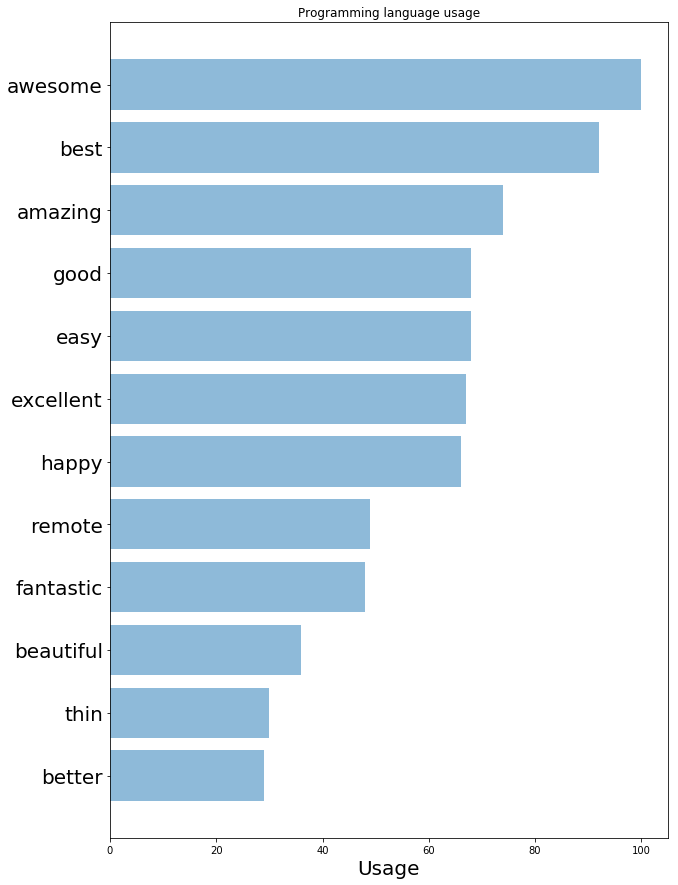

In [161]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
objects = [x[0] for x in pos_adjs]
y_pos = np.arange(len(objects))
performance = [x[1] for x in pos_adjs]
 
fig, ax = plt.subplots(1,1, figsize=(10,15))
ax.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects, fontsize=20)
ax.set_xlabel('Usage', fontsize=20)
ax.set_title('Programming language usage')
 
plt.show()

In [67]:
w2 = W2VReviewAnalyzer2()
w2.fit2(df_new)
df_trigrams = w2.df_prod.copy()
df_trigrams = df_trigrams.drop(['reviews'],axis=1)
df_trigrams = df_trigrams.rename(columns={'review_trigrams':'reviews'})
df_test = df_trigrams[df_trigrams['model'] == '55UJ6300']
lda = LdaReviewAnalyzer(num_topics=5)
lda.build_vectorize(df_test)
lda.fit(df_test, random_state=29)
lda.transform()

array([[0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.10042531, 0.10009948, 0.59908752, 0.1000016 , 0.10038608],
       [0.10042531, 0.10009948, 0.59908752, 0.1000016 , 0.10038608],
       ...,
       [0.79990274, 0.05000319, 0.05000242, 0.05008474, 0.05000691],
       [0.05063298, 0.05021021, 0.79742264, 0.05008245, 0.05165172],
       [0.05004939, 0.05004513, 0.05012115, 0.79965195, 0.05013238]])

In [49]:
df_test.head(2)

,rating,product,model,reviews
2780,1,LG Electronics 65UJ6300 65-Inch 4K Ultra HD Sm...,65UJ6300,good would say great pro con tvpros price righ...
2897,1,LG Electronics 65UJ6300 65-Inch 4K Ultra HD Sm...,65UJ6300,day age apps should_be_available manufacturer ...


In [50]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
print(lda.get_topics())

{'Topic 0:': [('price', 21.942089764295922), ('sound', 13.956453358524815), ('purchase', 13.342592234252152), ('happy', 12.487345423721075), ('television', 10.975187814556302), ('problem', 7.298069234605074), ('fantastic', 7.239208284750789), ('easy', 6.930573549768275), ('delivery', 6.397953169524066), ('awesome', 6.2320341942111)], 'Topic 1:': [('good', 63.38456705606963), ('quality', 20.52828705611699), ('price', 18.0037429312599), ('easy', 17.204113249114275), ('awesome', 17.012568468165743), ('delivery', 16.193226325713752), ('look', 15.995190379351829), ('excellent', 13.11050300590642), ('sound', 12.300538576717212), ('lot', 11.676734987122158)], 'Topic 2:': [('love', 55.587022933403716), ('amazing', 24.14636509599245), ('quality', 15.770059034603348), ('apps', 15.613460348828472), ('best', 15.474824633488225), ('look', 14.865690625532345), ('smart', 14.514405526525785), ('get', 12.86788784880833), ('old', 12.616234706097922), ('price', 11.910566626321215)], 'Topic 3:': [('work',

In [51]:
import ipywidgets
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda.lda_model, lda.data_vectorized, lda.vectorizer, mds='tsne')
pyLDAvis.display(panel)

In [132]:
sentence_stream = [[u'the', u'mayor', u'of', u'new', u'york', u'was', u'there'],
 [u'new', u'york', u'can', u'be', u'useful', u'sometimes']]

In [134]:
import spacy
from gensim.models import Phrases

In [135]:
bigram = Phrases(sentence_stream)

In [136]:

sent = [u'the', u'mayor', u'of', u'new', u'york', u'was', u'there']
print(bigram[sent])


['the', 'mayor', 'of', 'new', 'york', 'was', 'there']


In [152]:
from gensim.models import Phrases
documents = ["great tv the mayor of new york was there", "machine learning can be useful sometimes","new york mayor was present great tv",u"I love testing great tv"]

sentence_stream = [doc.split(" ") for doc in documents]
bigram = Phrases(sentence_stream, min_count=2, threshold=1)
sent = [u'the', u'mayor', u'of', u'new', u'york', u'was', u'there', u'great', u'tv']
print(bigram[sent])

['the', 'mayor', 'of', 'new', 'york', 'was', 'there', 'great_tv']
